# Project Unsupervised learning on your own

A work on text classification by Yann Faussurier.

this notebook contains annotation that was made by me and might have been reused in the report

In this exercise, we will try to implement a code able to give the sentiment of a given text.

We will use a database composed of three csv file which contains reddit posts and comments.

First, we will import the needed libraries for this which are numpy, pandas and tensorflow

In [1]:
%matplotlib inline
import json
import tensorflow as tf
import pandas as pd 
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Now because our dataset is placed in three different files, we will load them into panda datasets in order to concatenate all of them and get a unique dataframe for our data : 

In [3]:
df1=pd.read_csv("goemotions_1.csv")
df2=pd.read_csv("goemotions_2.csv")
df3=pd.read_csv("goemotions_3.csv")
df=pd.concat([df1,df2,df3])

We will now define our hyperparameters based on the example that was given with sarcasm, we will set vocab_size to 1000, embedding_dim to 16.

After some trial and errors, we have set max_length to 80 because it worked better.

We also set training_size to 190000 instead of 200000 in order to have a bigger testing_set, the number of data being 211225 it would let about 20 000 testing data.

In [4]:
vocab_size = 1000
embedding_dim = 16
max_length = 80
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 190000

Now we need to define the data that we will put into our neural network, we will set the 27 sentiment as target, and the input will be the text of the reddit comment/post

In [5]:
sentences = df['text']

labels=df.iloc[:,9:37]

We can now divide our data into a training and a test set using the parameters that we have defined above

In [6]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In a similar way as we did with the sarcasm dataset, we will use the tokenizer to tranform the vocabulary into tokens, and fit those tokens on the sentences of our data.
once we have done that we use the pad_sequences function to make each of our sentences the same length.

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [8]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

# Model Training

Because the fit will take a long time, we create a callback that will stop the training if the loss on the validation set doesnt change epochs by epochs

In [9]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [10]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.SimpleRNN(15,return_sequences=True),
#     tf.keras.layers.SimpleRNN(15),
#     tf.keras.layers.Dense(28, activation='sigmoid')
# ])
# model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

In [11]:
# #opt = tf.keras.optimizers.SGD(learning_rate=0.0001)
# LOSS=tf.keras.losses.BinaryCrossentropy(),
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.LSTM(100,dropout=0.5),
#     tf.keras.layers.Dense(28, activation='sigmoid')
# ])

# model.compile(loss=LOSS,optimizer="adam",metrics=['accuracy'])

Now we will create our neural network, to do so we need to think about our data.
Because we want to associate each comment with ONE sentiment, we are tempted to use multi-label encoding.

The problem is that our dataset contains duplicate, one tweet can appear multiple time and thus be associated with multiple sentiment.

This create a problem when we try to use CategoricalCrossentropyLosses and a softMax activation, if we do so, the loss will litteraly explode, because it will try to classify every comment with ONE emotion, but the duplicate will will tell the model that some comments correspond to two or three emotions.

Two solution offer to us, we could erase every duplicate and go back to single label encoding but a more simple solution would be to use a BinaryCrossentropyLosses and a sigmoid function : The sigmoid function does not have problems with duplicates, because every time it will encounter a tweet it it will reclassify it without taking in account the precedent encounter (i don't know if it make sense)

In [12]:


LOSS=tf.keras.losses.BinaryCrossentropy(),
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(35, activation='relu'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(28, activation='sigmoid')
])

model.compile(loss=LOSS,optimizer="adam",metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 16)            16000     
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 35)                44835     
                                                                 
 dropout_1 (Dropout)         (None, 35)                0         
                                                                 
 dense_1 (Dense)             (None, 28)                1008      
                                                                 
Total params: 61,843
Trainable params: 61,843
Non-traina

In [14]:
num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2,callbacks=[callback])

Epoch 1/10
5938/5938 - 22s - loss: 0.1550 - accuracy: 0.2968 - val_loss: 0.1368 - val_accuracy: 0.3438 - 22s/epoch - 4ms/step
Epoch 2/10
5938/5938 - 20s - loss: 0.1397 - accuracy: 0.3437 - val_loss: 0.1326 - val_accuracy: 0.3574 - 20s/epoch - 3ms/step
Epoch 3/10
5938/5938 - 21s - loss: 0.1369 - accuracy: 0.3514 - val_loss: 0.1306 - val_accuracy: 0.3646 - 21s/epoch - 3ms/step
Epoch 4/10
5938/5938 - 21s - loss: 0.1354 - accuracy: 0.3557 - val_loss: 0.1295 - val_accuracy: 0.3691 - 21s/epoch - 4ms/step
Epoch 5/10
5938/5938 - 21s - loss: 0.1346 - accuracy: 0.3576 - val_loss: 0.1290 - val_accuracy: 0.3755 - 21s/epoch - 3ms/step
Epoch 6/10
5938/5938 - 20s - loss: 0.1338 - accuracy: 0.3596 - val_loss: 0.1285 - val_accuracy: 0.3739 - 20s/epoch - 3ms/step
Epoch 7/10
5938/5938 - 20s - loss: 0.1334 - accuracy: 0.3613 - val_loss: 0.1282 - val_accuracy: 0.3776 - 20s/epoch - 3ms/step
Epoch 8/10
5938/5938 - 21s - loss: 0.1329 - accuracy: 0.3630 - val_loss: 0.1283 - val_accuracy: 0.3772 - 21s/epoch - 3

We can see that obtain a val accuracy of 0.3764 after 10 epochs, this is not a lot, but considering the complexity of classifying emotions it's not so bad.

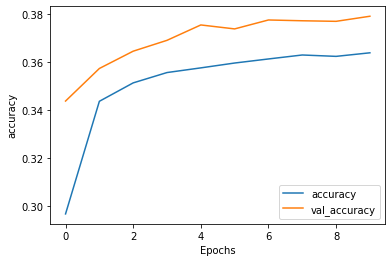

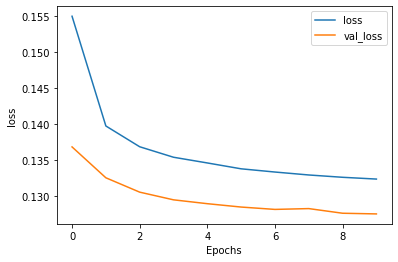

In [15]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Now we can question the data itself, by looking at the tweet and the emotions associated to it, it appear that 27 emotions is much more complexes than needed, some emotions are confusing to put on a tweet, and it seems overcomplicated to try to classify all theses comments with 27 commplexes emotions.

One idea that could solve this problem would be to simplify the 27 emotions to more basics emotions.

We chose to simplify the 27 emotions to 6 emotions : 
-Happy
-Fear or anger
-Shock
-Love
-Neutral
-Sadness

the simplification is of course not perfect and prone to improvement but let's see what we can get with this idea : 

In [16]:
df['Happy']=np.where((df['optimism']==1) | (df['admiration']==1) | (df['excitement']==1) | (df['approval']==1) | (df['relief']==1) | (df['amusement']==1) | (df['gratitude']==1) | (df['joy']==1),1,0)

df['Fear or anger']=np.where((df['anger']==1) | (df['annoyance']==1) | (df['disapproval']==1) | (df['fear']==1),1,0)

df['Shock']=np.where((df['confusion']==1) | (df['disappointment']==1) | (df['disgust']==1) | (df['embarrassment']==1) | (df['surprise']==1),1,0)

df['Love']=np.where((df['love']==1) | (df['desire']==1) | (df['caring']==1),1,0)

df['Neutral']=np.where((df['neutral']==1) | (df['realization']==1) | (df['disgust']==1) | (df['embarrassment']==1) | (df['surprise']==1) | (df['curiosity']==1),1,0)

df['Sadness']=np.where((df['sadness']==1) | (df['remorse']==1) | (df['grief']==1),1,0)



In [17]:
labels = df.iloc[:,37:]

In [18]:
LOSS=tf.keras.losses.BinaryCrossentropy(),
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(35, activation='relu'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(6, activation='sigmoid')
])

model.compile(loss=LOSS,optimizer="adam",metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 80, 16)            16000     
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 35)                44835     
                                                                 
 dropout_3 (Dropout)         (None, 35)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                 216       
                                                                 
Total params: 61,051
Trainable params: 61,051
Non-trai

In [20]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]


tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)



training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [24]:
num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2,callbacks=[callback])

Epoch 1/10
5938/5938 - 28s - loss: 0.3597 - accuracy: 0.5087 - val_loss: 0.3563 - val_accuracy: 0.5072 - 28s/epoch - 5ms/step
Epoch 2/10
5938/5938 - 30s - loss: 0.3600 - accuracy: 0.5087 - val_loss: 0.3565 - val_accuracy: 0.5136 - 30s/epoch - 5ms/step
Epoch 3/10
5938/5938 - 20s - loss: 0.3596 - accuracy: 0.5085 - val_loss: 0.3561 - val_accuracy: 0.5059 - 20s/epoch - 3ms/step
Epoch 4/10
5938/5938 - 20s - loss: 0.3590 - accuracy: 0.5101 - val_loss: 0.3558 - val_accuracy: 0.5083 - 20s/epoch - 3ms/step
Epoch 5/10
5938/5938 - 20s - loss: 0.3591 - accuracy: 0.5105 - val_loss: 0.3561 - val_accuracy: 0.5051 - 20s/epoch - 3ms/step
Epoch 6/10
5938/5938 - 22s - loss: 0.3588 - accuracy: 0.5099 - val_loss: 0.3569 - val_accuracy: 0.5063 - 22s/epoch - 4ms/step


We can see that we now obtain a precision of 51%, which is better, by simplifying the emotions, we were able to better aprehend each comment's emotions

# going into the territory of multi-label encoding

We've shown that by simplifying emotions, we could get a satisfying result of 51%, but 51% is i believe not the best score possible.

We've talked before about the idea that when concatenating the three dataset, we've seen some sentence having multiples labels and we simply ignored the problem by using a sigmoid as the output activation function.
We've said to ourselves that emmotions emitted by a text are too complex to classify one text with one emotion ammong 27. and thus, the solution we choose was to simplify the 27 emotions to simpler one.

But what if a better and more obvious solution was right under our eyes : letting text having multiple emotions attributed to them.
By doing so we would go in the territory of multi-label encoding, the model would have to change a bit, as we would need to put a softmax as output.

Let's see how this idea works out.





The following command will sum every identical text, so that now, one text will have several emotions and not just one

In [48]:
df = df[['text',
 'admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise',
 'neutral']].groupby('text').sum()

In [49]:
df[df > 1] = 1
df = df.add_suffix('').reset_index()

In [51]:
sentences = df['text']

labels=df[[
 'admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise',
 'neutral']]

Now we can apply the same preprocessing that we applied in our previous models

In [52]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [53]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [54]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

For this model, i inspired myself of a model used in our last work in the NLP class, which correspond to the actual case, the model is mainly composed of two LSTM layer with a return sequence in the first in order for them to communicate properly. this model takes a veeery long time to run because of the number of units that i used, but it guarantee us a good result

In [66]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length)) #The embedding layer
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150,return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(75))) #Our LSTM layer
model.add(tf.keras.layers.Dense(28,activation='sigmoid'))


model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision()])


In [67]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 80, 16)            16000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 80, 300)          200400    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 150)              225600    
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 28)                4228      
                                                                 
Total params: 446,228
Trainable params: 446,228
Non-trainable params: 0
_________________________________________________________________


In [64]:
training_labels.shape

(57732, 28)

In [68]:
num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2,callbacks=[callback])

Epoch 1/10
1805/1805 - 893s - loss: 0.2760 - precision_2: 0.6460 - 893s/epoch - 495ms/step
Epoch 2/10
1805/1805 - 808s - loss: 0.2498 - precision_2: 0.7134 - 808s/epoch - 448ms/step
Epoch 3/10
1805/1805 - 804s - loss: 0.2382 - precision_2: 0.7318 - 804s/epoch - 445ms/step
Epoch 4/10
1805/1805 - 821s - loss: 0.2313 - precision_2: 0.7287 - 821s/epoch - 455ms/step
Epoch 5/10
1805/1805 - 820s - loss: 0.2268 - precision_2: 0.7306 - 820s/epoch - 455ms/step
Epoch 6/10
1805/1805 - 809s - loss: 0.2237 - precision_2: 0.7324 - 809s/epoch - 448ms/step
Epoch 7/10
1805/1805 - 819s - loss: 0.2211 - precision_2: 0.7328 - 819s/epoch - 454ms/step
Epoch 8/10
1805/1805 - 809s - loss: 0.2191 - precision_2: 0.7334 - 809s/epoch - 448ms/step
Epoch 9/10
1805/1805 - 822s - loss: 0.2172 - precision_2: 0.7352 - 822s/epoch - 455ms/step
Epoch 10/10
1805/1805 - 830s - loss: 0.2154 - precision_2: 0.7348 - 830s/epoch - 460ms/step


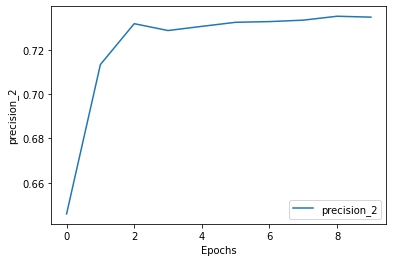

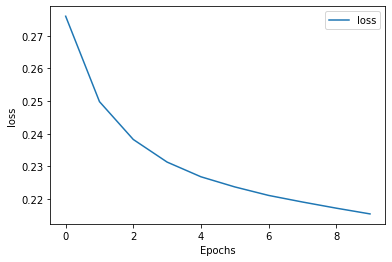

In [72]:
def plot_graphs_bis(history, string):
  plt.plot(history.history[string])
  #plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs_bis(history, "precision_2")
plot_graphs_bis(history, "loss")

We can see that we now get a precision of 73,5% which is so much better than the previous model, acknoledging that a text can have multiple emotions is key to makeing the model efficient.